# Segmentation of Indian Traffic

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib

<pre>
1. You can download the data from this link, and extract it

2. All your data will be in the folder "data" 

3. Inside the data you will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/data.rar

Streaming output truncated to the last 5000 lines.
  inflating: data/images/377/frame28480_leftImg8bit.jpg  
  inflating: data/images/377/frame28699_leftImg8bit.jpg  
  inflating: data/images/377/frame28808_leftImg8bit.jpg  
  inflating: data/images/377/frame29080_leftImg8bit.jpg  
  inflating: data/images/377/frame29271_leftImg8bit.jpg  
  inflating: data/images/377/frame29435_leftImg8bit.jpg  
  inflating: data/images/377/frame29653_leftImg8bit.jpg  
  inflating: data/images/377/frame29817_leftImg8bit.jpg  
  inflating: data/images/377/frame30062_leftImg8bit.jpg  
  inflating: data/images/377/frame30199_leftImg8bit.jpg  
  inflating: data/images/377/frame3039_leftImg8bit.jpg  
  inflating: data/images/377/frame30417_leftImg8bit.jpg  
  inflating: data/images/377/frame30499_leftImg8bit.jpg  
  inflating: data/images/377/frame30608_leftImg8bit.jpg  
  inflating: data/images/377/frame30744_leftImg8bit.jpg  
  inflating: data/images/377/frame30908_leftImg8bit.jpg  
  inflating: data/imag

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
#https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
import os
from os import path
def getListOfFiles(dirName):
    listOfFile = os.listdir(dirName)
    allFiles = list()
    for entry in listOfFile:
        fullPath = os.path.join(dirName, entry)
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath[9:])
    return allFiles       

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files

    images = getListOfFiles(root_dir + '/images')
    mask = []
    for i in images:
      i = i.replace('images','mask').replace('leftImg8bit.jpg','gtFine_polygons.json')
      mask.append(i)
    data_df = pd.DataFrame({'images':images,'json':mask})
    return data_df


In [ ]:
root_dir = '/content/data'
data_df = return_file_names_df(root_dir)
data_df.head()

images  \
0  data/images/201/frame2519_leftImg8bit.jpg   
1  data/images/201/frame3179_leftImg8bit.jpg   
2  data/images/201/frame4079_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame0299_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame2519_gtFine_polygons.json  
1  data/mask/201/frame3179_gtFine_polygons.json  
2  data/mask/201/frame4079_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame0299_gtFine_polygons.json

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="200" height="100">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
#https://www.geeksforgeeks.org/read-json-file-using-python/
import json
def unique_objects(filename):
  labels = []
  polygon = []
  f = open(filename)
  data = json.load(f)
  for i in data['objects']:
    labels.append(i['label'])
    polygon.append(i['polygon'])
  width = data['imgWidth']
  height = data['imgHeight']
  return labels, polygon, width, height

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it

    unique_labels = []
    for i in data_df['json']:
      unique_labels.extend(unique_objects(i)[0])
    unique_labels = list(set(unique_labels))
    return unique_labels
  

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to devide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    # it will process all the objects in that file and returns
    
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image
    label = unique_objects(file)[0]
    
    # vertexlist: it should be list of list of vertices in tuple formate 
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image
    vertex = unique_objects(file)[1]
    vertexlist = []
    for i in vertex:
      vertexlist.append([tuple(ele) for ele in i])
    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    w = unique_objects(file)[2]
    # height of the image
    h = unique_objects(file)[3]

    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

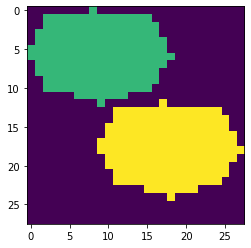

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
#https://www.geeksforgeeks.org/create-a-directory-in-python/
os.mkdir('/content/data/output')

In [ ]:
def compute_masks(data_df):
  files = []
  for i in tqdm(data_df['json']):
    w, h, label, vertexlist = get_poly(i)
  
  # after you have computed the vertexlist plot that polygon in image like this
    img = Image.new("RGB", size=(w, h))
    img1 = ImageDraw.Draw(img)
    for l in range(len(vertexlist)):
      if len(vertexlist[l]) > 1:
        img1.polygon(vertexlist[l], fill = label_clr[label[l]])

  # after drawing all the polygons that we collected from json file, 
  # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    s = i.replace('mask', 'output').replace('json', 'png')
    folder = s[:15]
    if not os.path.isdir(folder):
      os.mkdir(folder)
    img = np.array(img)
    im = Image.fromarray(img[:, :, 0])
    im.save(s)
    
  # after saving the image into disk, store the path in a list
    files.append(s)
  # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
  data_df['mask'] = files

  return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|██████████| 4008/4008 [05:24<00:00, 12.35it/s]


images  \
0  data/images/201/frame2519_leftImg8bit.jpg   
1  data/images/201/frame3179_leftImg8bit.jpg   
2  data/images/201/frame4079_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame0299_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame2519_gtFine_polygons.json   
1  data/mask/201/frame3179_gtFine_polygons.json   
2  data/mask/201/frame4079_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame0299_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame2519_gtFine_polygons.png  
1  data/output/201/frame3179_gtFine_polygons.png  
2  data/output/201/frame4079_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame0299_gtFine_polygons.png

In [ ]:
#daving the final dataframe to a csv file
data_df.to_csv('preprocessed_data.csv', index=False)

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1" 

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

https://www.jeremyjordan.me/semantic-segmentation/
1. Dice is a statistic used to measure the similarity or overlap between two samples.

  Dice = (2|A∩B|)/(|A|+|B|)

  For segmentation tasks, |A∩B| represents a total number of pixel overlaps  between the predicted and the actual image.

  |A| - the total number of pixels in the predicted image.

  |B| - the total number of pixels in the actual image.

  In order to quantify above two, either simple sum or squared sum is used.

  The 2 in the numerator is used because common pixels between A and B are counted twice.

2. The range of dice is (0 - 1). A value of 1 denotes there is a complete/perfect overlap between the predicted and actual image.

3. (1 - Dice) also called soft Dice loss is a loss function that is minimized. The numerator represents the overlap of pixels of the two images at the local scale while the denominator represents the total pixels of each image at the global scale. Dice loss considers the loss of information both locally and globally, which is important to get excellent results.

4. This loss function overcomes the disadvantage of other loss functions like pixel-wise cross-entropy where the average of per-pixel loss is considered, which can be problematic if your image has an unbalanced representation of classes. E.g. if 90% of pixels belong to the background and 10% of other pixels belong to different classes, when pixel-wise accuracy is calculated it will be 90% which is biased.


### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-au4c0io5
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-au4c0io5
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=67f57258052b317e2b88024e76d3941a27a114fb3f217cd7ba1bc9720ebf1ef3
  Stored in directory: /tmp/pip-ephem-wheel-cache-rwcj0sbm/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import numpy as np
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
tf.keras.backend.clear_session()

In [ ]:
df = pd.read_csv('/content/preprocessed_data.csv')
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size = 0.15, random_state=9)
train.shape, test.shape

((3406, 3), (602, 3))

In [ ]:
#Image augumentation
aug1 = iaa.Fliplr(1)
aug2 = iaa.Emboss(alpha=(1), strength=1)
aug3 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug4 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

In [ ]:
class Dataset:   

    def __init__(self, data, CLASSES):
        
        self.ids = data
        # the paths of images
        self.images_fps = data['images'].values
        # the paths of segmentation images
        self.masks_fps = data['mask'].values
        # giving labels for each class
        self.class_values = CLASSES

    def __getitem__(self, i):

        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED) 
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_NEAREST)
        mask = cv2.resize(mask,(256,256))
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        
        #image augmentation
        a = np.random.uniform(0,1)
        if self.images_fps[i] in train:
          if a<0.2:
            image = aug1.augment_image(image)
            image_mask = aug1.augment_image(mask)
          elif a<0.4:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(mask)
          elif a<0.6:
            image = aug3.augment_image(image)
            image_mask = aug3.augment_image(mask)
          else:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(mask)

        #onehotencoding the masked image
        image_masks = [(mask == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float64')


        return image, image_mask

    def __len__(self):
        return len(self.ids)

In [ ]:
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values())))
train_dataset = Dataset(train,CLASSES)
test_dataset  = Dataset(test,CLASSES)

BATCH_SIZE=3
train_dataloader = Dataloder(train_dataset, batch_size=3)
test_dataloader = Dataloder(test_dataset, batch_size=3)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(3, 256, 256, 3)
(3, 256, 256, 21)


In [ ]:
image, mask = train_dataset[52]
visualize(image = image, sky = mask[:, :,16], road = mask[:,:,1])

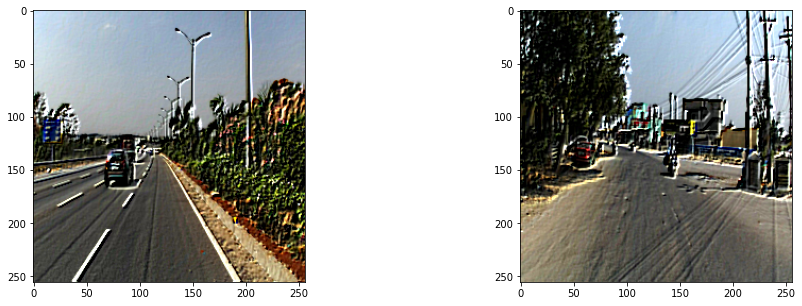

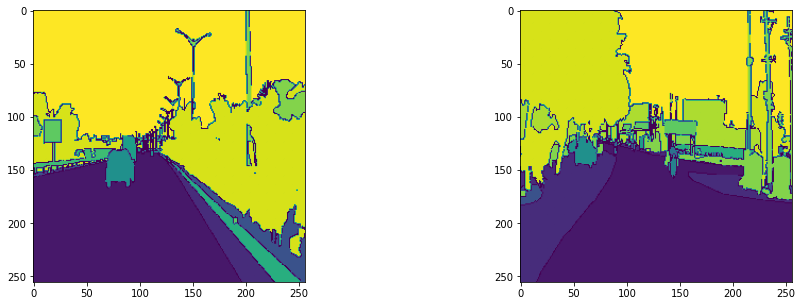

In [ ]:
train_images, mask_images = train_dataloader[51]
plt.figure(figsize=(16, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(train_images[i])
plt.figure(figsize=(16, 5))
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(np.argmax(mask_images[i], axis=-1))

In [ ]:
import segmentation_models as sm
from segmentation_models import Unet
sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


In [ ]:
model = Unet('resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))
model.summary()

85532672/85521592 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)            

In [ ]:
# https://github.com/qubvel/segmentation_models
tf.keras.backend.clear_session()
from segmentation_models.metrics import iou_score
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 5, mode = 'max',min_lr=0.00001, factor = 0.1),

]

In [ ]:
train_steps = train.shape[0]//15
test_steps = test.shape[0]//15
train_steps

227

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch = train_steps,epochs = 10, validation_data = test_dataloader, 
                              validation_steps = test_steps, callbacks = callbacks)

Epoch 1/10
227/227 [==============================] - 48s 213ms/step - loss: 0.8351 - iou_score: 0.1636 - val_loss: 0.8379 - val_iou_score: 0.1681 - lr: 0.0010
Epoch 2/10
227/227 [==============================] - 49s 216ms/step - loss: 0.7931 - iou_score: 0.1942 - val_loss: 0.8346 - val_iou_score: 0.1742 - lr: 0.0010
Epoch 3/10
227/227 [==============================] - 48s 210ms/step - loss: 0.7757 - iou_score: 0.2090 - val_loss: 0.7817 - val_iou_score: 0.2053 - lr: 0.0010
Epoch 4/10
227/227 [==============================] - 47s 208ms/step - loss: 0.7568 - iou_score: 0.2225 - val_loss: 0.7945 - val_iou_score: 0.2050 - lr: 0.0010
Epoch 5/10
227/227 [==============================] - 47s 208ms/step - loss: 0.7398 - iou_score: 0.2353 - val_loss: 0.7364 - val_iou_score: 0.2388 - lr: 0.0010
Epoch 6/10
227/227 [==============================] - 47s 207ms/step - loss: 0.7279 - iou_score: 0.2439 - val_loss: 0.7269 - val_iou_score: 0.2472 - lr: 0.0010
Epoch 7/10
227/227 [====================

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch = train_steps,epochs = 10, validation_data = test_dataloader, 
                              validation_steps = test_steps, callbacks = callbacks)

Epoch 1/10
227/227 [==============================] - 47s 205ms/step - loss: 0.6845 - iou_score: 0.2790 - val_loss: 0.6809 - val_iou_score: 0.2783 - lr: 0.0010
Epoch 2/10
227/227 [==============================] - 48s 212ms/step - loss: 0.6808 - iou_score: 0.2817 - val_loss: 0.6754 - val_iou_score: 0.2855 - lr: 0.0010
Epoch 3/10
227/227 [==============================] - 46s 202ms/step - loss: 0.6753 - iou_score: 0.2862 - val_loss: 0.7368 - val_iou_score: 0.2404 - lr: 0.0010
Epoch 4/10
227/227 [==============================] - 46s 202ms/step - loss: 0.6655 - iou_score: 0.2937 - val_loss: 0.6870 - val_iou_score: 0.2785 - lr: 0.0010
Epoch 5/10
227/227 [==============================] - 46s 204ms/step - loss: 0.6678 - iou_score: 0.2929 - val_loss: 0.7131 - val_iou_score: 0.2567 - lr: 0.0010
Epoch 6/10
227/227 [==============================] - 42s 187ms/step - loss: 0.6662 - iou_score: 0.2934 - val_loss: 0.6654 - val_iou_score: 0.2911 - lr: 0.0010
Epoch 7/10
227/227 [====================

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch = train_steps,epochs = 5, validation_data = test_dataloader, 
                              validation_steps = test_steps, callbacks = callbacks)

Epoch 1/5
227/227 [==============================] - 43s 188ms/step - loss: 0.4498 - iou_score: 0.5050 - val_loss: 0.5322 - val_iou_score: 0.4476 - lr: 0.0010
Epoch 2/5
227/227 [==============================] - 47s 205ms/step - loss: 0.4591 - iou_score: 0.4982 - val_loss: 0.4626 - val_iou_score: 0.4951 - lr: 0.0010
Epoch 3/5
227/227 [==============================] - 47s 206ms/step - loss: 0.4542 - iou_score: 0.5020 - val_loss: 0.4610 - val_iou_score: 0.4961 - lr: 0.0010
Epoch 4/5
227/227 [==============================] - 46s 203ms/step - loss: 0.4443 - iou_score: 0.5093 - val_loss: 0.4669 - val_iou_score: 0.4934 - lr: 0.0010
Epoch 5/5
227/227 [==============================] - 47s 207ms/step - loss: 0.4507 - iou_score: 0.5055 - val_loss: 0.4543 - val_iou_score: 0.5023 - lr: 0.0010


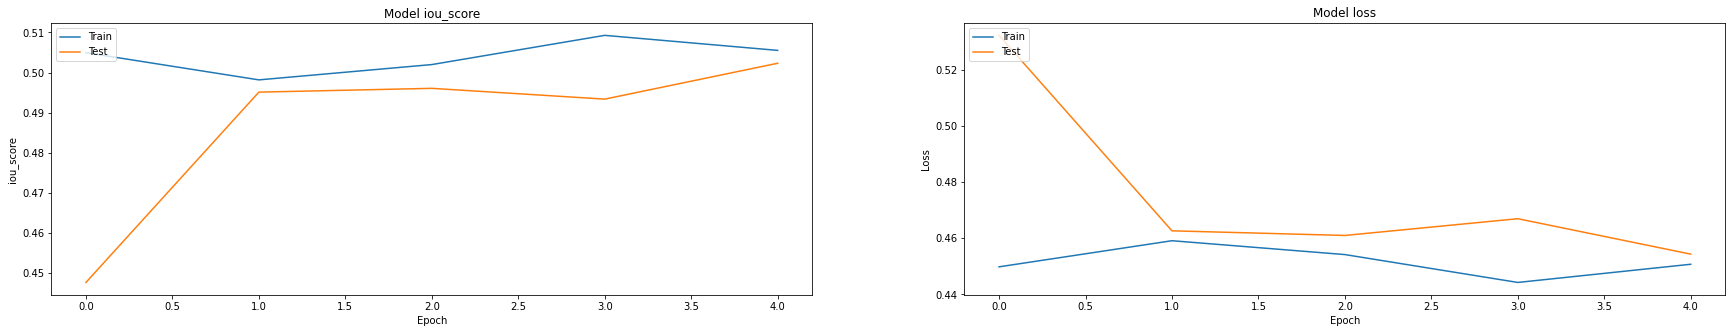

In [ ]:
#code from reference notebook given
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

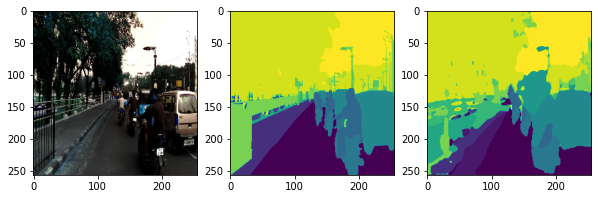

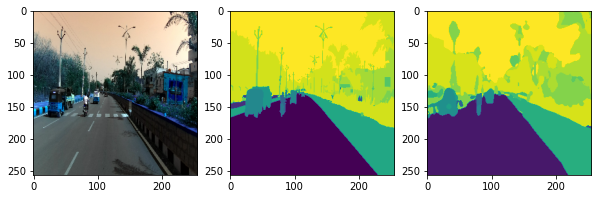

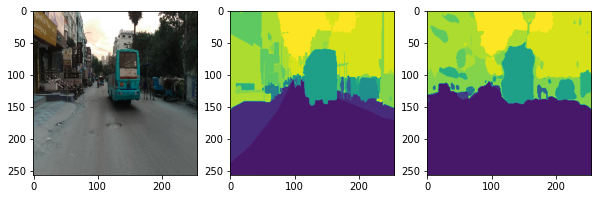

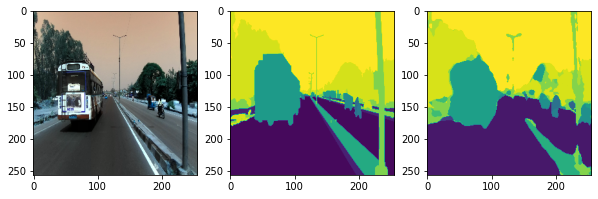

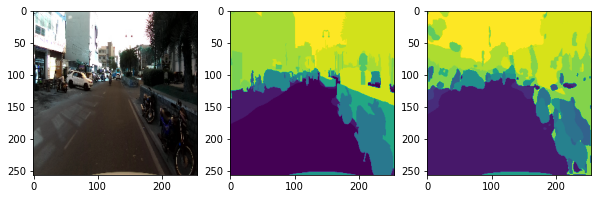

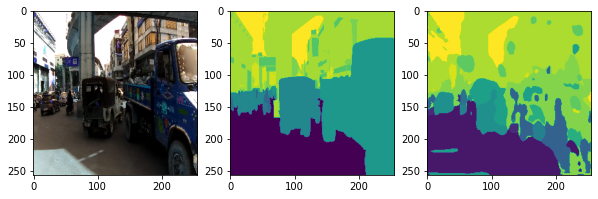

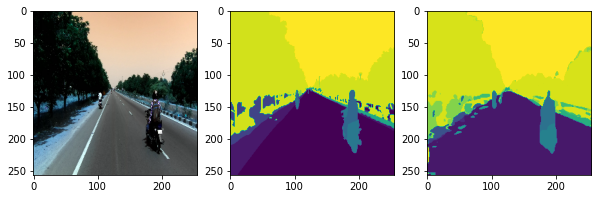

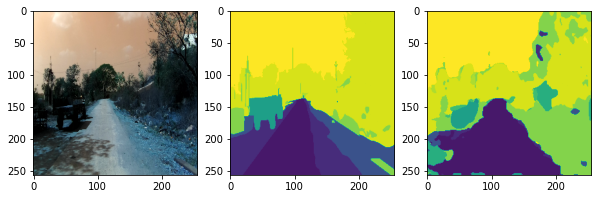

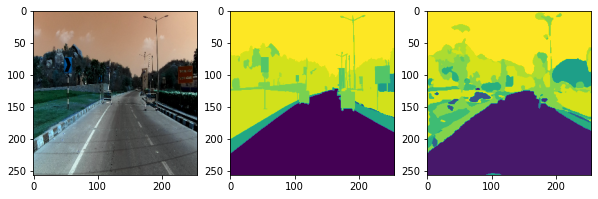

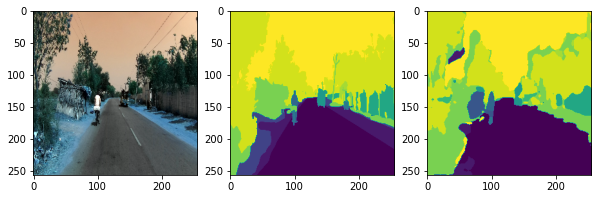

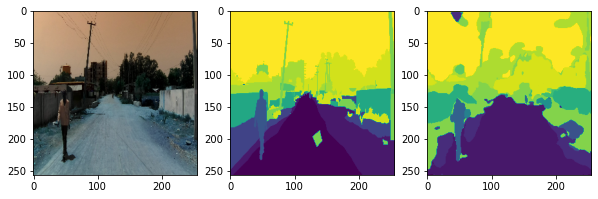

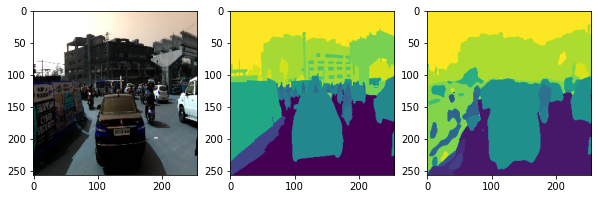

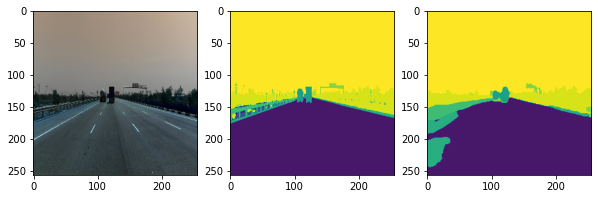

In [ ]:
cnt = 0
for i in range(len(test)):
    cnt =  cnt + 1
    #original image
    image = cv2.imread(list(test['images'])[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(list(test['mask'])[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.show()

    if cnt == 15:
      break

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
tf.keras.backend.clear_session()

/usr/local/lib/python3.7/dist-packages/keras/backend.py:450: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1, name="conv block"):
        super().__init__(name=name)

        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        
        self.conv_1 = Conv2D(self.F1,(1,1),strides=(self.stride,self.stride),padding='same')
        self.bn_1 = BatchNormalization(axis=3)

        self.conv_2 = Conv2D(self.F2,(self.kernel,self.kernel),strides=(1,1),padding='same')
        self.bn_2 = BatchNormalization(axis=3)

        self.conv_3 = Conv2D(self.F3,(1,1),strides=(1,1),padding='same')
        self.bn_3 = BatchNormalization(axis=3)

        self.conv_4 = Conv2D(self.F3,(self.kernel,self.kernel),strides=(self.stride,self.stride),padding='same')
        self.bn_4 = BatchNormalization(axis=3)
        
        self.relu = Activation("relu")
        self.add = Add()
        
    def call(self, X):
        
        X_input = X

        conv1 = self.conv_1(X)
        bn1 = self.bn_1(conv1)
        act1 = self.relu(bn1)
        conv2 = self.conv_2(act1)
        bn2 = self.bn_2(conv2)
        act2 = self.relu(bn2)
        conv3 = self.conv_3(act2)
        bn3 = self.bn_3(conv3)
        
        X_input = self.conv_4(X_input)
        X_input = self.bn_4(X_input)
        X_input = self.relu(X_input)
        X = self.add([X_input, bn3])
        X = self.relu(X)
        
        return X

In [ ]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], name="identity block"):
        super().__init__(name=name)

        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        
        self.conv_1 = Conv2D(self.F1, (1,1), (1,1), padding="same")
        self.bn_1 = BatchNormalization(axis=3)

        self.conv_2 = Conv2D(self.F2, (self.kernel,self.kernel), (1,1), padding="same")
        self.bn_2 = BatchNormalization(axis=3)

        self.conv_3 = Conv2D(self.F3, (1,1), (1,1), padding="same")
        self.bn_3 = BatchNormalization(axis=3)
        self.relu = Activation("relu")
        
        self.add = Add()
        
        
    def call(self, X):
        
        X_input = X
        
        conv1 = self.conv_1(X)
        bn1 = self.bn_1(conv1)
        act1 = self.relu(bn1)
        conv2 = self.conv_2(act1)
        bn2 = self.bn_2(conv2)
        act2 = self.relu(bn2)
        conv3 = self.conv_3(act2)
        bn3 = self.bn_3(conv3)
        
        X = self.add([bn3, X_input])
        X = self.relu(X)
        
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>: 
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>: 
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow` 
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling 
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, input_dim, output_dim, channels, name="global_flow"):
        super().__init__(name=name)
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.channels = channels
        
        self.conv1 = Conv2D(64,kernel_size=(1,1),strides=(1,1),padding='same')
        self.global_avg_pool = GlobalAveragePooling2D()
        self.bn = BatchNormalization(axis=3)
        self.relu = Activation("relu")
        self.upsample = UpSampling2D(size=(self.input_dim,self.output_dim),interpolation='bilinear')
        
    def call(self, X):
        
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        bn1 = self.bn(global_avg)
        act1 = self.relu(bn1)
        conv1 = self.conv1(act1)
        X = self.upsample(conv1)
        
        return X

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, name="context_flow"):
        super().__init__(name=name)
        
        self.conv_1 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_2 = Conv2D(64, kernel_size=(3,3), strides=(1,1), padding="same")
        self.conv_3 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        self.conv_4 = Conv2D(64, kernel_size=(1,1), strides=(1,1), padding="same")
        
        self.concatenate = Concatenate()
        self.avg_pool = AveragePooling2D(pool_size=(2,2))
        self.relu = Activation("relu")
        self.sigmoid = Activation("sigmoid")
        self.add = Add()
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear') 
        
        
    def call(self, X):        
      
        INP, FLOW = X[0], X[1] 
        concat = self.concatenate([INP, FLOW])
        avg_pooling = self.avg_pool(concat)
        conv1 = self.conv_1(avg_pooling)
        conv2 = self.conv_2(conv1)
        conv3 = self.conv_3(conv2)
        act1 = self.relu(conv3)
        conv4 = self.conv_4(act1)
        act2 = self.sigmoid(conv4)        
        multi = self.multiply([conv2, act2])
        add = self.add([conv2, multi])
        X = self.upsample(add)
        
        return X

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>
 
* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.
 
<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):
    def __init__(self, name="feature_selection"):
        super().__init__(name=name)
        
        self.conv_1 = Conv2D(32, (3,3), (1,1), padding="same")
        self.global_avg_pool = GlobalAveragePooling2D()
        self.conv_2 = Conv2D(32 ,kernel_size=(1,1),padding='same')
        self.bn = BatchNormalization()
        self.act_sigmoid = Activation('sigmoid')
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2),interpolation='bilinear')
        
    def call(self, X):
        
        X = self.conv_1(X)
        global_avg = self.global_avg_pool(X)
        global_avg= tf.expand_dims(global_avg, 1)
        global_avg = tf.expand_dims(global_avg, 1)
        conv1= self.conv_2(global_avg)
        bn1= self.bn(conv1)
        Y = self.act_sigmoid(bn1)
        output = self.multiply([X, Y])
        FSM_Conv_T = self.upsample(output)
        
        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, name="global_conv_net"):
        super().__init__(name=name)

        self.conv_1  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_2  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_3  = Conv2D(32,kernel_size=(1,7),padding='same')
        self.conv_4  = Conv2D(32,kernel_size=(7,1),padding='same')
        self.conv_5  = Conv2D(32,kernel_size=(3,3),padding='same')
        self.add = Add()
        
    def call(self, X):
        
        conv1 = self.conv_1(X)
        conv2= self.conv_2(conv1)
        conv3 = self.conv_4(X)
        conv4 = self.conv_3(conv3)
        add1 = self.add([conv2,conv4])
        conv5 = self.conv_5(add1)
        X = self.add([conv5,add1])
        
        return X

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
X_input = Input(shape=(256,256,3))
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

c1 = convolutional_block(kernel=3,  filters=[4,4,8], stride=2, name='convolutional_block_1')(X)
I11 = identity_block(name='identity_block_11')(c1)

c2 = convolutional_block(kernel=3,  filters=[8,8,16], stride=2, name='convolutional_block_2')(I11)
I21 = identity_block(kernel=3,  filters=[8,8,16], name='identity_block_21')(c2)
I22 = identity_block(kernel=3,  filters=[8,8,16], name='identity_block_22')(I21)

c3 = convolutional_block(kernel=3,  filters=[16,16,32], stride=1, name='convolutional_block_3')(I22)
I31 = identity_block(kernel=3,  filters=[16,16,32], name='identity_block_31')(c3)
I32 = identity_block(kernel=3,  filters=[16,16,32], name='identity_block_32')(I31)
I33 = identity_block(kernel=3,  filters=[16,16,32], name='identity_block_33')(I32)

c4 = convolutional_block(kernel=3,  filters=[32,32,64], stride=1, name='convolutional_block_4')(I33)
I41 = identity_block(kernel=3,  filters=[32,32,64], name='identity_block_41')(c4)
I42 = identity_block(kernel=3,  filters=[32,32,64], name='identity_block_42')(I41)
I43 = identity_block(kernel=3,  filters=[32,32,64], name='identity_block_43')(I42)
I44 = identity_block(kernel=3,  filters=[32,32,64], name='identity_block_44')(I42)

input_dim = I44.shape[1]
output_dim = I44.shape[2]
channels = I44.shape[-1]
GF1 = global_flow(input_dim, output_dim, channels)(I44)

Y = [I44, GF1]
CF1 = context_flow(name='context_flow_1')(Y)

Z = [I44, CF1]
CF2 = context_flow(name='context_flow_2')(Z)

W = [I44, CF1]
CF3 = context_flow(name='context_flow_3')(W)

out = Add()([GF1, CF1, CF2, CF3])
fsm1 = fsm()(out)
agcn1 = agcn()(c1)

concat = Concatenate()([fsm1, agcn1])
final_conv = Conv2D(filters=21, kernel_size=(1,1), strides=(1,1), padding="same",name='convolutional_block_final')(concat)
up_samp = UpSampling2D((4,4), interpolation="bilinear")(final_conv)
output = Activation("softmax")(up_samp)

* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

In [ ]:
# write the complete architecutre

model = Model(inputs = X_input, outputs = output)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 256, 256, 6  0           []                               
                                4)]                                                               
                                                                                                  
 convolutional_block_1 (convolu  (None, 128, 128, 8)  5160       ['input_7[0][0]']                
 tional_block)                                                                                    
                                                                                                  
 identity_block_11 (identity_bl  (None, 128, 128, 8)  288        ['convolutional_block_1[1][0]']  
 ock)                                                                                       

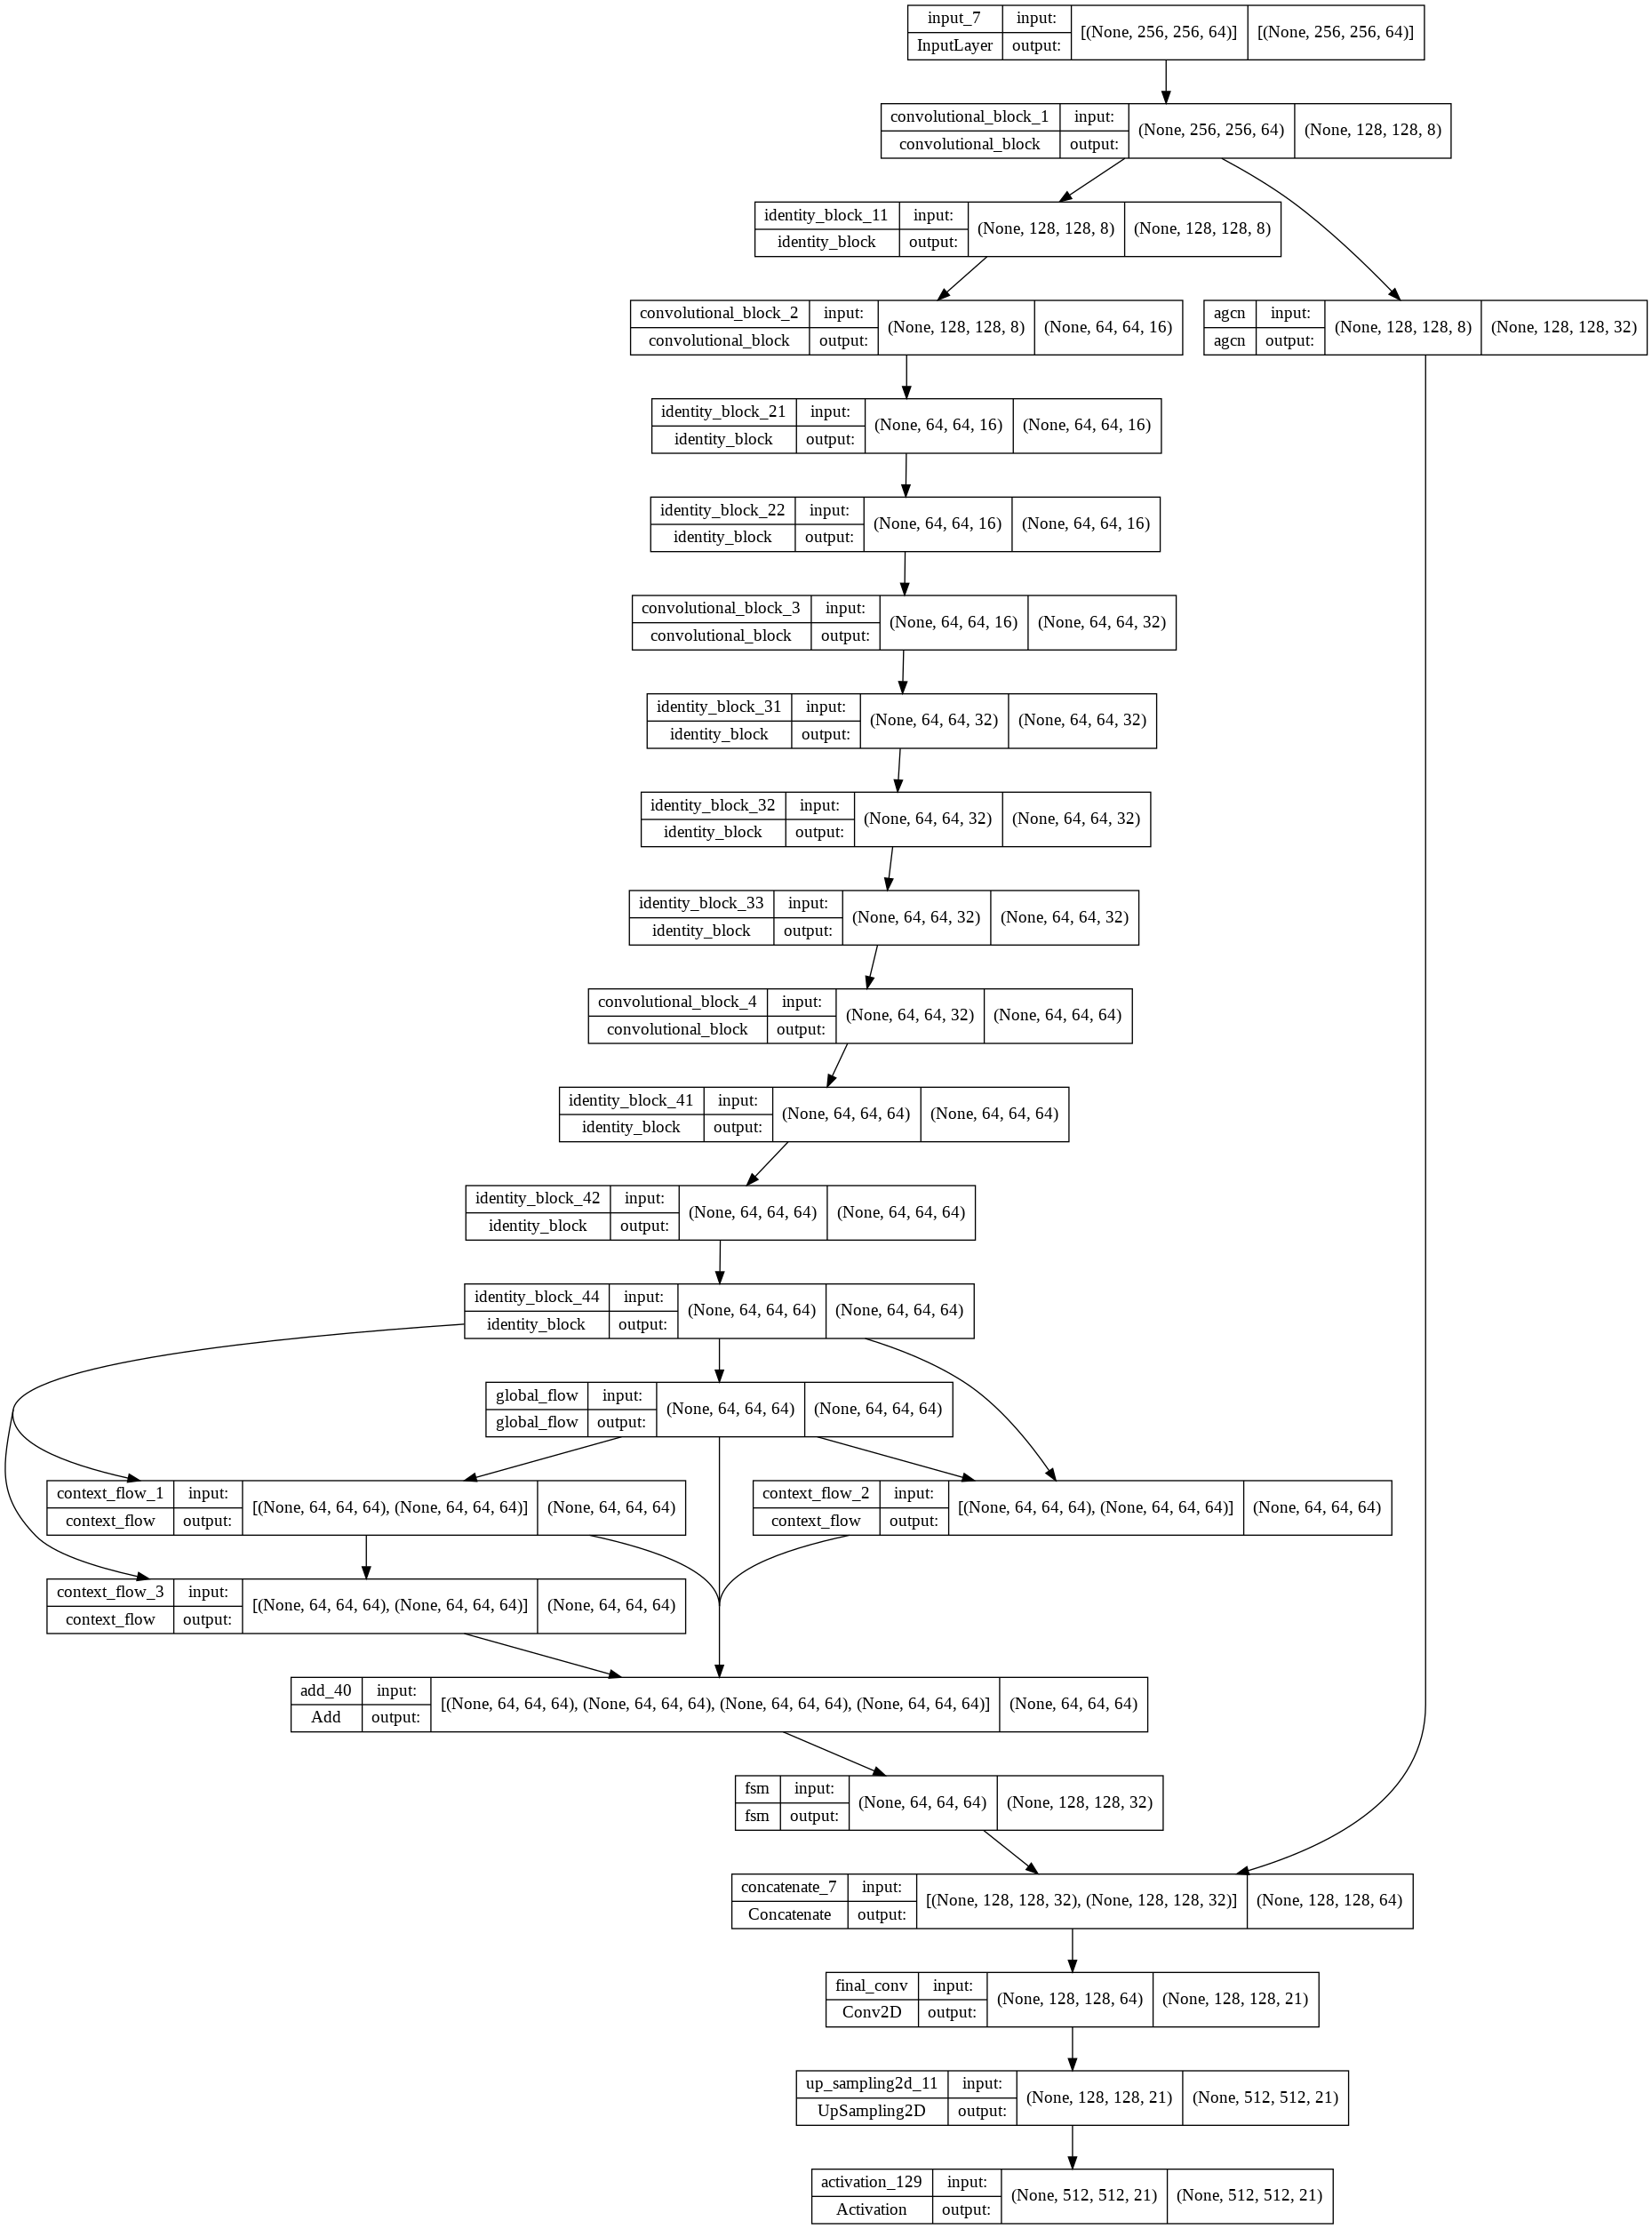

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
# Dataset for train images
CLASSES = list(np.unique(list(label_clr.values())))
train_dataset = Dataset(train,CLASSES)
test_dataset  = Dataset(test,CLASSES)

BATCH_SIZE=3
train_dataloader = Dataloder(train_dataset, batch_size=3)
test_dataloader = Dataloder(test_dataset, batch_size=3)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='max', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_iou_score', patience = 5, mode = 'max',min_lr=0.00001, factor = 0.1),

]

(3, 256, 256, 3)
(3, 256, 256, 21)


In [ ]:
import segmentation_models as sm
from segmentation_models.metrics import iou_score

optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optim, focal_loss, metrics=[iou_score])

In [ ]:
train_steps = train.shape[0]//8
test_steps = test.shape[0]//8
train_steps

350

In [ ]:
history = model.fit(train_dataloader, steps_per_epoch = train_steps,epochs = 5, validation_data = test_dataloader, 
                              validation_steps = test_steps, callbacks = callbacks)

Epoch 1/5
350/350 [==============================] - 77s 220ms/step - loss: 0.8723 - iou_score: 0.1100 - val_loss: 0.9836 - val_iou_score: 0.0513 - lr: 0.0010
Epoch 2/5
350/350 [==============================] - 78s 222ms/step - loss: 0.7777 - iou_score: 0.1999 - val_loss: 0.7365 - val_iou_score: 0.2981 - lr: 0.0010
Epoch 3/5
350/350 [==============================] - 77s 220ms/step - loss: 0.6006 - iou_score: 0.3728 - val_loss: 0.5950 - val_iou_score: 0.3779 - lr: 0.0010
Epoch 4/5
350/350 [==============================] - 78s 222ms/step - loss: 0.5863 - iou_score: 0.3835 - val_loss: 0.9089 - val_iou_score: 0.2417 - lr: 0.0010
Epoch 5/5
350/350 [==============================] - 78s 222ms/step - loss: 0.6035 - iou_score: 0.3701 - val_loss: 0.5985 - val_iou_score: 0.3771 - lr: 0.0010


In [ ]:
model.optimizer.learning_rate = 0.0005
history = model.fit(train_dataloader, steps_per_epoch = train_steps,epochs = 5, validation_data = test_dataloader, 
                              validation_steps = test_steps, callbacks = callbacks)

Epoch 1/5
350/350 [==============================] - 77s 219ms/step - loss: 0.5714 - iou_score: 0.3925 - val_loss: 0.5883 - val_iou_score: 0.3810 - lr: 5.0000e-04
Epoch 2/5
350/350 [==============================] - 78s 222ms/step - loss: 0.5563 - iou_score: 0.4039 - val_loss: 0.5652 - val_iou_score: 0.3999 - lr: 5.0000e-04
Epoch 3/5
350/350 [==============================] - 76s 218ms/step - loss: 0.5526 - iou_score: 0.4070 - val_loss: 0.5475 - val_iou_score: 0.4105 - lr: 5.0000e-04
Epoch 4/5
350/350 [==============================] - 78s 223ms/step - loss: 0.5517 - iou_score: 0.4072 - val_loss: 0.5564 - val_iou_score: 0.4065 - lr: 5.0000e-04
Epoch 5/5
350/350 [==============================] - 76s 216ms/step - loss: 0.5454 - iou_score: 0.4119 - val_loss: 0.5425 - val_iou_score: 0.4147 - lr: 5.0000e-04


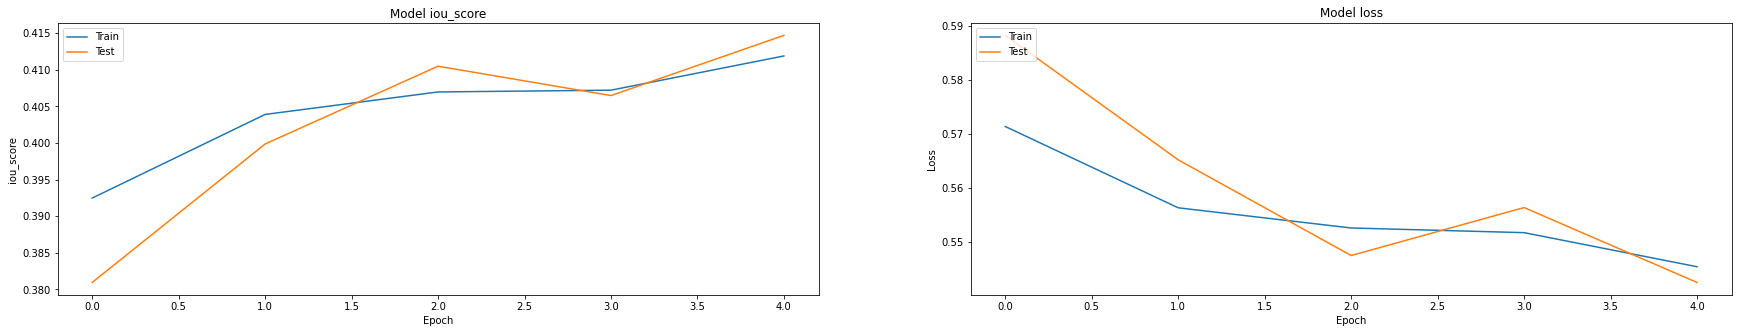

In [ ]:
#code from reference notebook given
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

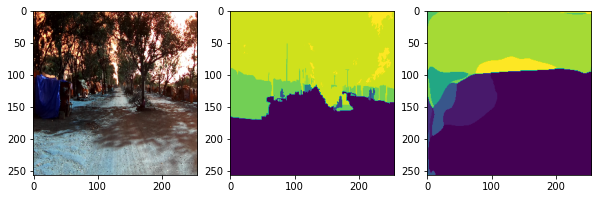

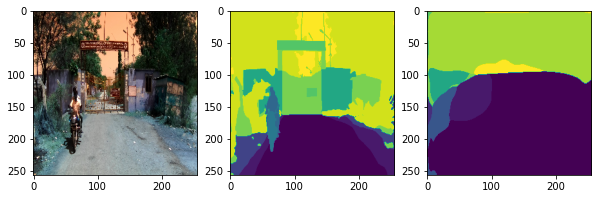

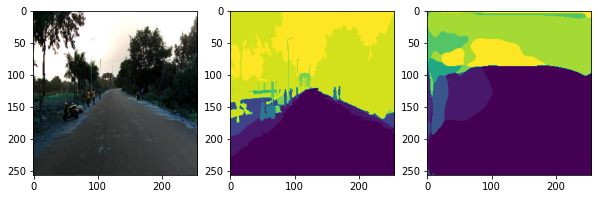

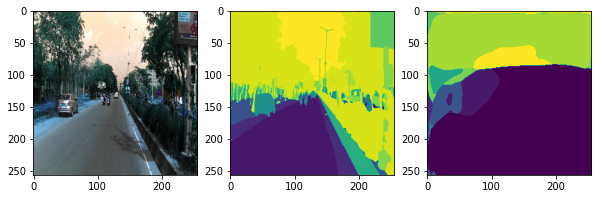

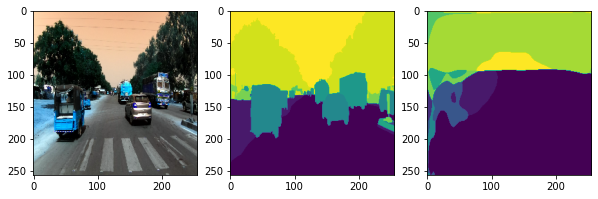

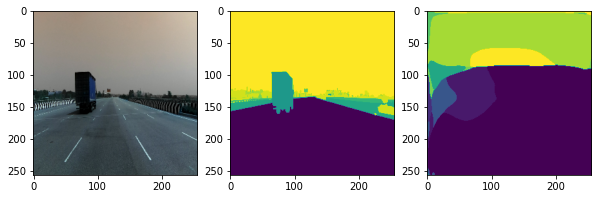

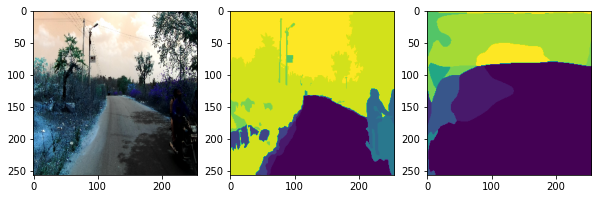

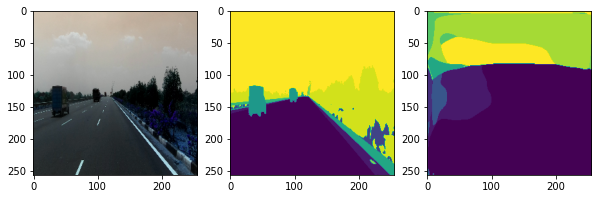

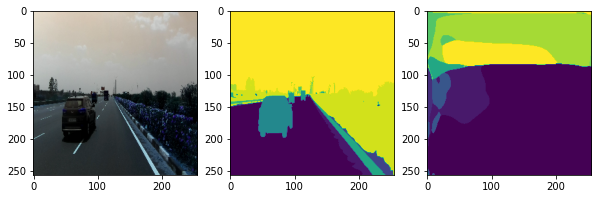

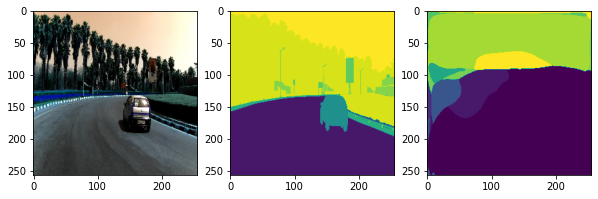

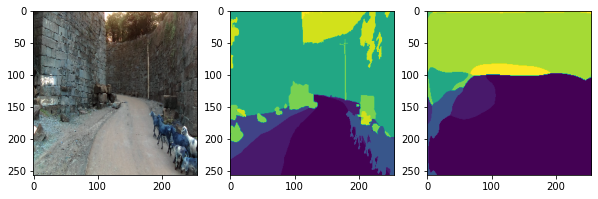

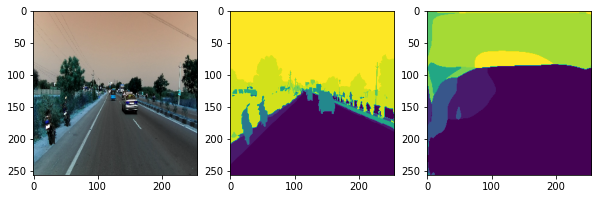

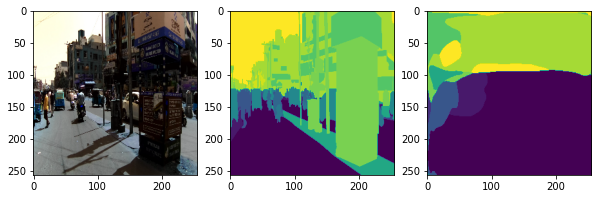

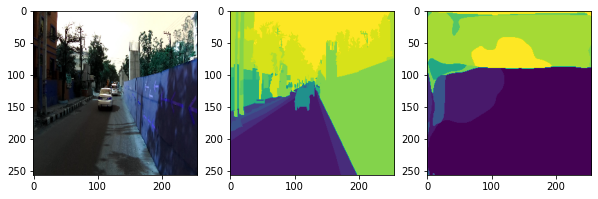

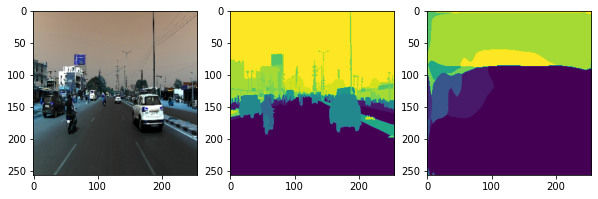

In [ ]:
cnt = 0
for i in range(len(test)):
    cnt =  cnt + 1
    #original image
    image = cv2.imread(list(test['images'])[i], cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256)) 
    
    #predicted segmentation map
    predicted  = model.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted, axis=-1)
    
    #original segmentation map
    image_mask = cv2.imread(list(test['mask'])[i], cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))
    

    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)
    plt.subplot(133)
    plt.imshow(predicted[0])
    plt.show()

    if cnt == 15:
      break

REFERENCE - https://blog.paperspace.com/understanding-canet-architecture/

### Usefull tips:
* use "interpolation=cv2.INTER_NEAREST" when you are resizing the image, so that it won't mess with the number of classes
* keep the images in the square shape like $256*256$ or $512*512$
* Carefull when you are converting the (W, H) output image into (W, H, Classes)
* Even for the canet, use the segmentation model's losses and the metrics
* The goal of this assignment is make you familier in with computer vision problems, image preprocessing, building complex architectures and implementing research papers, so that in future you will be very confident in industry
* you can use the tensorboard logss to see how is yours model's training happening
* use callbacks that you have implemented in previous assignments

### Things to keep in mind

* You need to train  above built model and plot the train and test losses.
* Make sure there is no overfitting, you are free play with the identity blocks in C1, C2, C3, C4
* before we apply the final sigmoid activation, you can add more conv layers or BN or dropouts etc
* you are free to use any other optimizer or learning rate or weights init or regularizations